In [24]:
import matplotlib.pyplot as plt

from utils import data_loader

import os
import sys
import pathlib

import numpy as np

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import expand_labels
from scipy.ndimage import gaussian_filter
from skimage import measure


ROOT_PATH = str(pathlib.Path().absolute())
DATA_STORAGE_PATH = '/data_storage/'
STORAGE_PATH = ROOT_PATH + DATA_STORAGE_PATH

DATASET_PATH = '/datasets/final_data'
FINAL_DATASET_PATH = ROOT_PATH + DATASET_PATH

TRAIN_PATH_IMAGES = FINAL_DATASET_PATH + '/train/images/'
TEST_PATH_IMAGES = FINAL_DATASET_PATH + '/test/images/'
VALI_PATH_IMAGES = FINAL_DATASET_PATH + '/validation/images/'

TRAIN_PATH_MASKS = FINAL_DATASET_PATH + '/train/masks/'
TEST_PATH_MASKS = FINAL_DATASET_PATH + '/test/masks/'
VALI_PATH_MASKS = FINAL_DATASET_PATH + '/validation/masks/'

In [2]:
train_data = data_loader.load_train_data('final_data', is_dots_expanded=False, expand_size=1)
test_data = data_loader.load_test_data('final_data', is_dots_expanded=False, expand_size=1)

[35.]


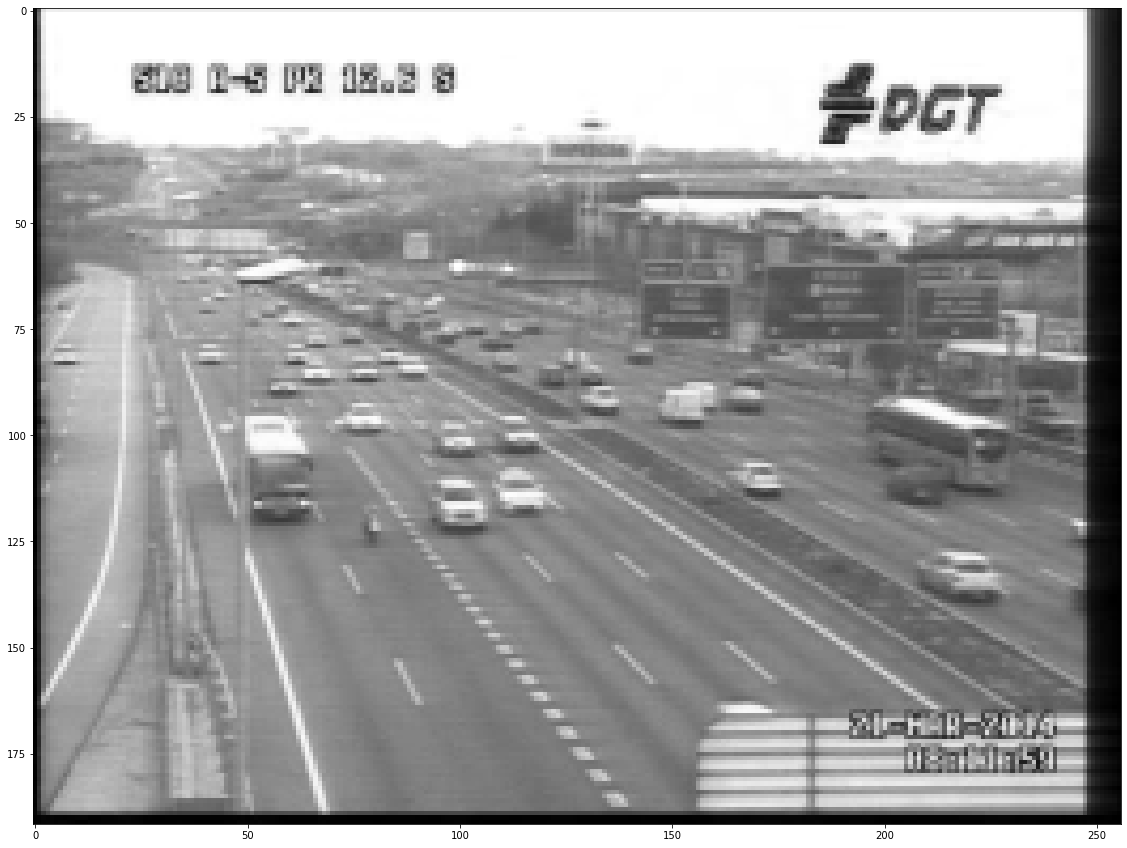

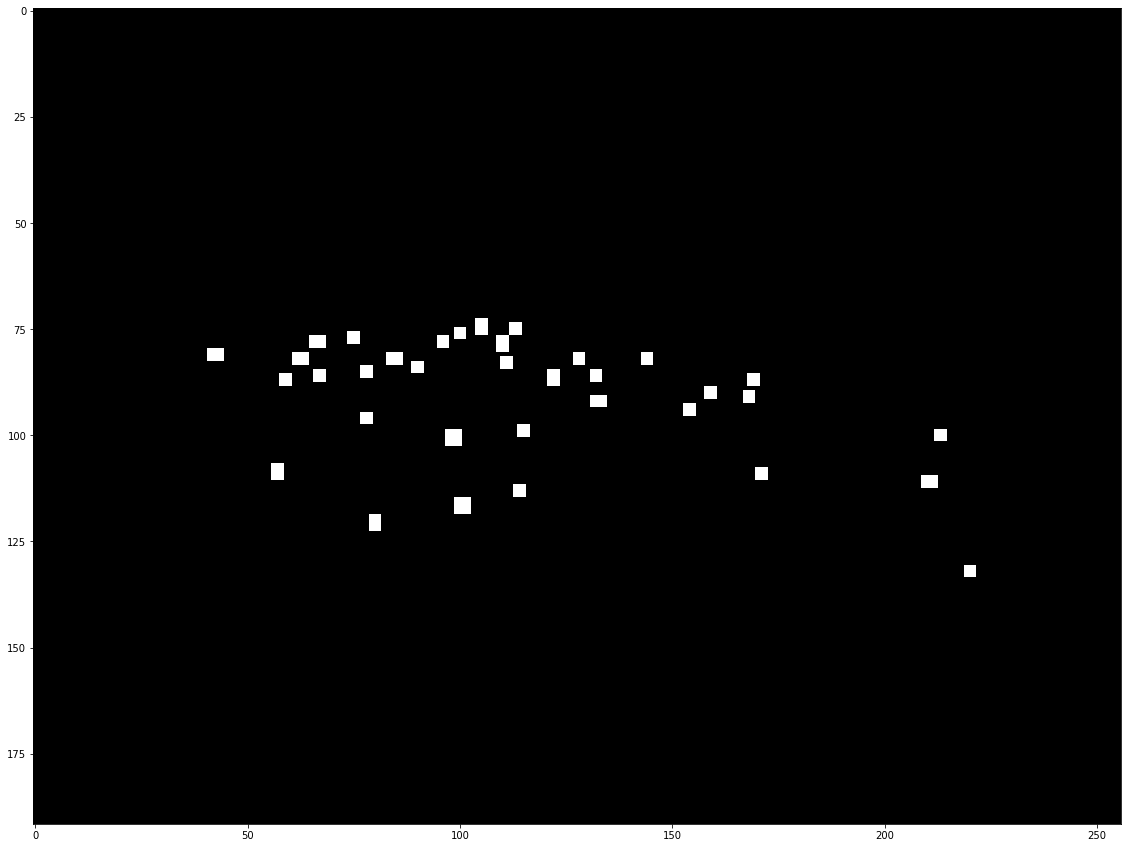

In [3]:
show_index = 10
s1 = train_data['train_data'][show_index]
l1 = train_data['train_label_data'][show_index]
lc1 = train_data['train_count_label_data'][show_index]

print(lc1)


plt.figure(figsize=(30, 15))
plt.imshow(s1, cmap='gray')
plt.show()

plt.figure(figsize=(30, 15))
plt.imshow(l1, cmap='gray')
plt.show()

In [11]:
ls1 = l1.reshape(192, 256)

In [12]:
ls1.shape

(192, 256)

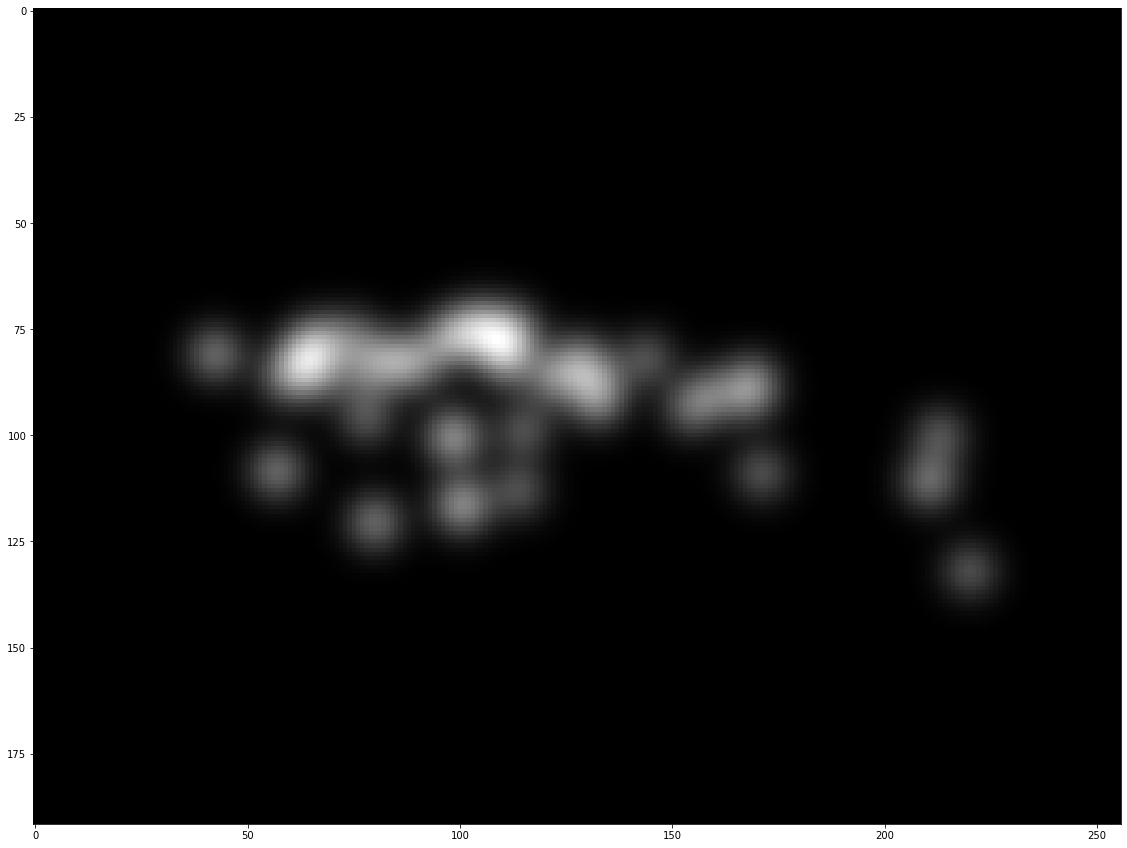

In [17]:
lsg1 = gaussian_filter(ls1, sigma=5)
plt.figure(figsize=(30, 15))
plt.imshow(lsg1, cmap='gray')
plt.show()

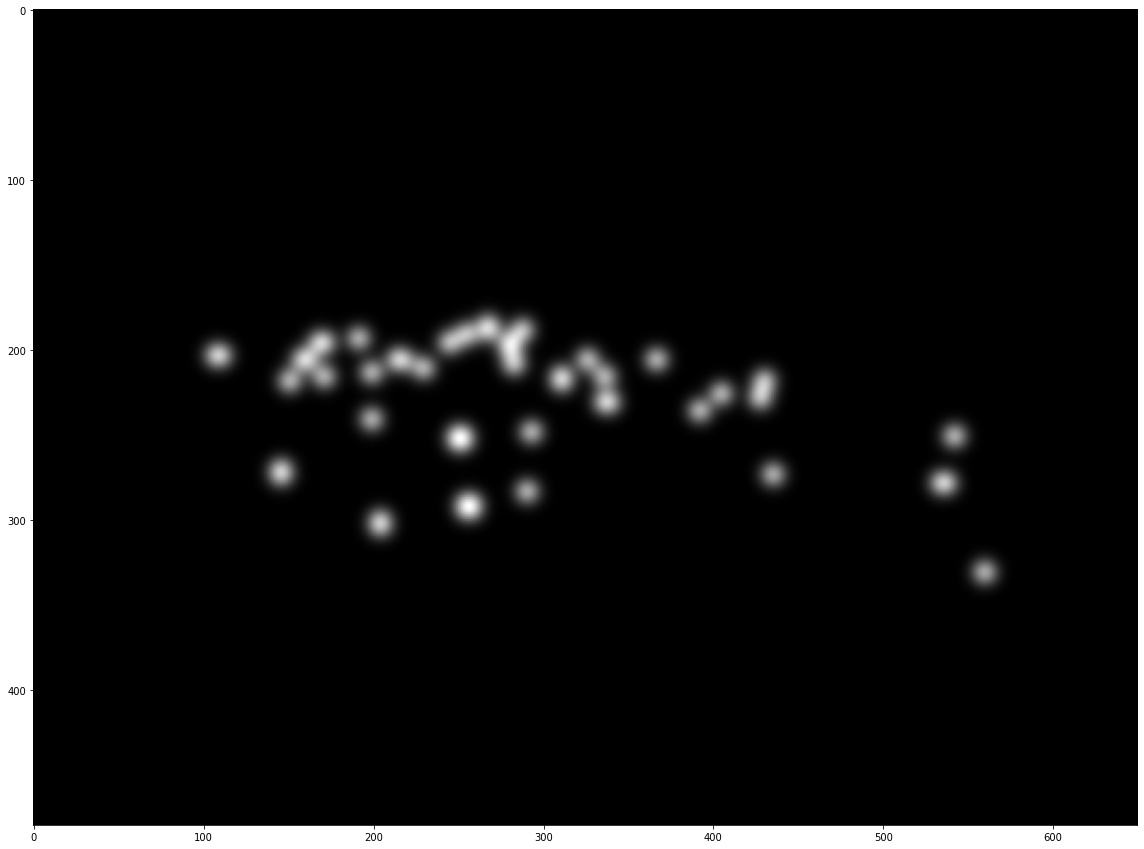

In [22]:
lrs1 = resize(l1, (480, 650), mode='constant', preserve_range=True)
lrsg1 = gaussian_filter(lrs1, sigma=5)
plt.figure(figsize=(30, 15))
plt.imshow(lrsg1, cmap='gray')
plt.show()

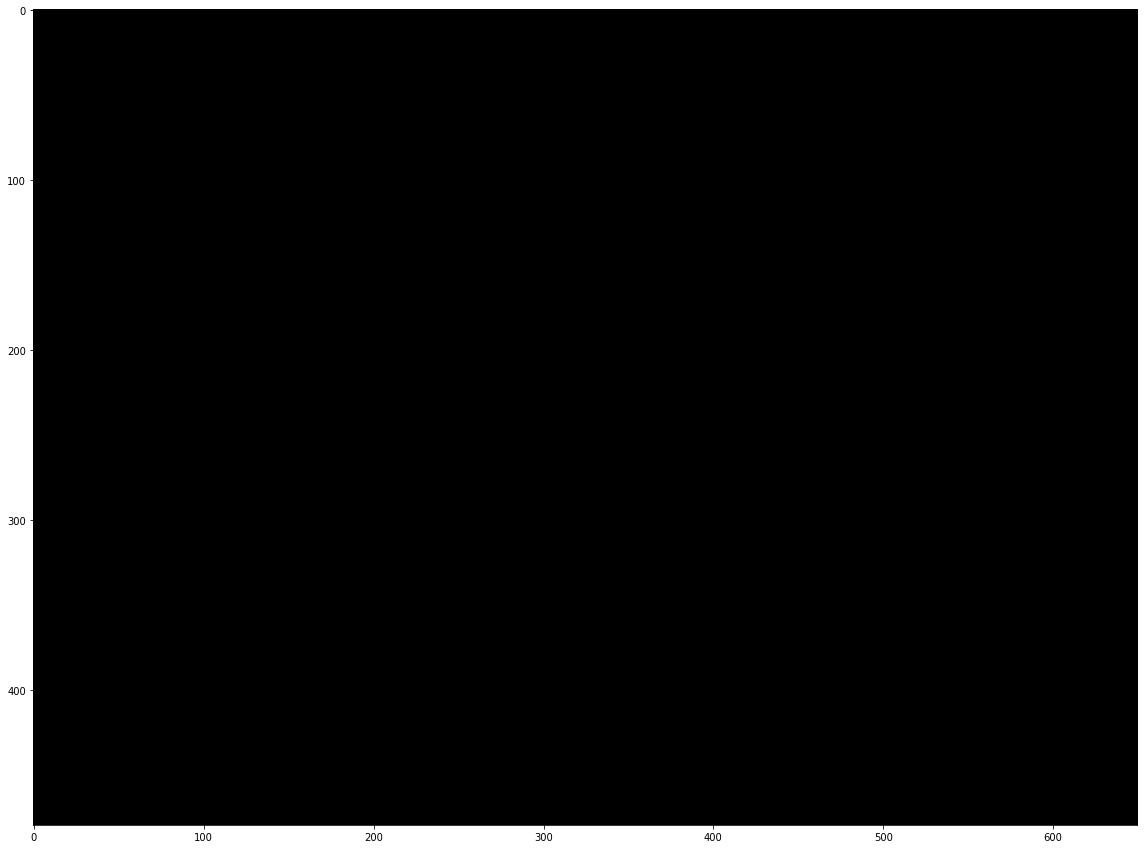

In [29]:
lrs1 = resize(l1, (480, 650), mode='constant', preserve_range=True)
lrsg1 = gaussian_filter(lrs1, sigma=5)
lrsg1 = measure.label(lrsg1)
plt.figure(figsize=(30, 15))
plt.imshow(lrsg1, cmap='gray')
plt.show()

In [31]:
np.sum(lrsg1)

0